Plot stats of Raw and Abstracted Event logs (Event log consist of only TP and TN patinets)

In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.cluster import DBSCAN

#from pm4py.objects.log.util import get_log_representation as get_
from Levenshtein import distance as levenshtein_distance
from sklearn.cluster import AgglomerativeClustering

from scipy.spatial.distance import squareform
from scipy.cluster.hierarchy import linkage, fcluster, dendrogram
import seaborn as sns

In [2]:
# Train and Test set (To find only TP and TN patients)

Train_set_ground_truth_and_predicted_label = pd.read_csv('/Users/psenevirathn/Desktop/PhD/Coding/Python/input_csv_files/label_train_actual_and_predicted_with_updated_ground_truth.csv')

Test_set_ground_truth_and_predicted_label = pd.read_csv('/Users/psenevirathn/Desktop/PhD/Coding/Python/input_csv_files/label_test_actual_and_predicted_with_updated_ground_truth.csv')

In [3]:
def determine_class(row):
    if row['HIT_label_actual'] == 1 and row['HIT_label_predicted'] == 1:
        return 'TP'
    elif row['HIT_label_actual'] == 1 and row['HIT_label_predicted'] == 0:
        return 'FN'
    elif row['HIT_label_actual'] == 0 and row['HIT_label_predicted'] == 1:
        return 'FP'
    elif row['HIT_label_actual'] == 0 and row['HIT_label_predicted'] == 0:
        return 'TN'


In [4]:
Train_set_ground_truth_and_predicted_label['data_set'] = 'train'
Test_set_ground_truth_and_predicted_label['data_set'] = 'test'

both_train_test_labels = pd.concat([Train_set_ground_truth_and_predicted_label, Test_set_ground_truth_and_predicted_label], axis=0).drop('Unnamed: 0', axis=1)

 # Apply the function to each row in the DataFrame
both_train_test_labels['class'] = both_train_test_labels.apply(determine_class, axis=1)

# 1. Analysing Trajectory lengths Distribution WITHOUT Abstraction


In [5]:
# Import files - Raw event log (contain all the patients, not only TP and TN)

events_WITHOUT_abstraction = pd.read_csv('/Users/psenevirathn/Desktop/PhD/Coding/Trajectories/Input/Events_WITHOUT_abstraction_From_BigQuery_V19_1.csv')

# hadm_id count = 13415

/var/folders/hd/ds7hts1d50j2wcpcm9y14v440000gn/T/ipykernel_59329/1098256528.py:3: DtypeWarning: Columns (2) have mixed types. Specify dtype option on import or set low_memory=False.
  events_WITHOUT_abstraction = pd.read_csv('/Users/psenevirathn/Desktop/PhD/Coding/Trajectories/Input/Events_WITHOUT_abstraction_From_BigQuery_V19_1.csv')


In [6]:
# save the formatted event log to check the process map in DISCO

print(events_WITHOUT_abstraction)

           hadm_id                             event  value     details  \
0         27675397                 bgART_pCO2_normal  50818       bgART   
1         28259228  bgART_Potassium, Whole Blood_low  50822       bgART   
2         28259228  bgART_Potassium, Whole Blood_low  50822       bgART   
3         28259228              bgART_Lactate_normal  50813       bgART   
4         29538539                    bgART_pCO2_low  50818       bgART   
...            ...                               ...    ...         ...   
14277936  25660703      temperature_vitalsign_normal    NaN  VitalSigns   
14277937  29446555      temperature_vitalsign_normal    NaN  VitalSigns   
14277938  29446555      temperature_vitalsign_normal    NaN  VitalSigns   
14277939  29446555      temperature_vitalsign_normal    NaN  VitalSigns   
14277940  20331048      temperature_vitalsign_normal    NaN  VitalSigns   

                   event_time  
0         2156-12-23 02:30:00  
1         2136-10-02 18:06:00  
2  

In [7]:
full_raw_event_log_with_patient_class = pd.merge(events_WITHOUT_abstraction, both_train_test_labels, on='hadm_id', how='left')[
        ['hadm_id', 'event', 'event_time', 'HIT_label_actual', 'HIT_label_predicted', 'class']]

In [8]:
raw_event_log_TP_and_TN_only = full_raw_event_log_with_patient_class[
        (full_raw_event_log_with_patient_class['class'] == 'TP') | (full_raw_event_log_with_patient_class['class'] == 'TN')]
# 12355 - hadm_ids

In [9]:
seq_length_raw_event_log = raw_event_log_TP_and_TN_only.groupby('hadm_id').agg(count=('hadm_id', lambda x: len(x)),
                                                        sequence=('event', lambda x: x)).reset_index()

seq_length_raw_event_log.sort_values(by='count', ascending=False, inplace=True)

In [10]:
patient_count = seq_length_raw_event_log['hadm_id'].nunique() # 12355

## 1.1 Plot trace length distribution as a Histogram

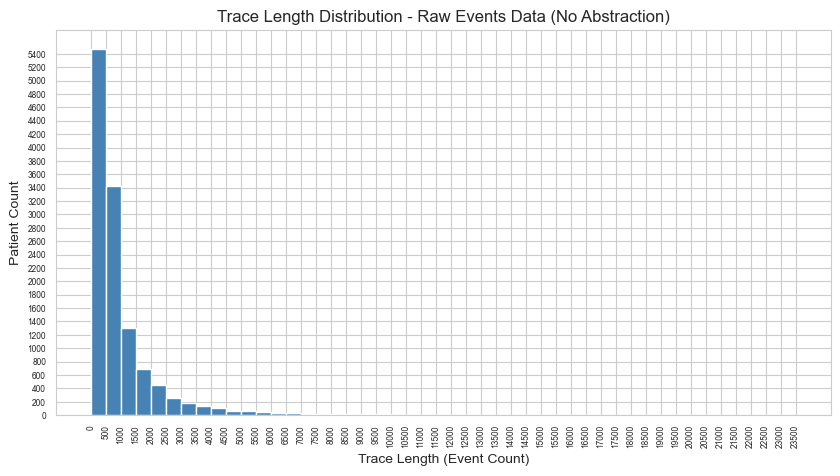

In [11]:
plt.figure(figsize=(10, 5))  # Create a new figure with specified size

list_seq_lengths_raw_event_log = seq_length_raw_event_log['count'].tolist()

# Custom bins

bins_raw = list(range(0, max(list_seq_lengths_raw_event_log)+500, 500)) 

# Plot histogram
hist_data_raw = plt.hist(list_seq_lengths_raw_event_log, bins=bins_raw, color='#4682B4') # edgecolor='black', 
#87CEEB - Light blue , Steel Blue: #4682B4 Light Green: #98FB98 , Cornflower Blue: #6495ED, Light Pink: #FFB6C1 , Light Gray: #D3D3D3 # FA8072 - Salmon pink

# Set x ticks
plt.xticks(bins_raw, rotation='vertical', fontsize=6)

# Set y ticks

# print(plt.hist(list_seq_lengths_of_each_hadm_id_when_HIT_positive, bins=bins)) # returns an array of two arrays, where first array contain frquency of each bin, and the second array contain bin edges values

plt.yticks(range(0, int(max(hist_data_raw[0]) + 1), 200),fontsize=6) 
# Add axis labels and title
plt.xlabel('Trace Length (Event Count)')
plt.ylabel('Patient Count')
plt.title('Trace Length Distribution - Raw Events Data (No Abstraction)')

# Add grid
plt.grid(True)

# Show plot
plt.show()

## 1.2 Plot Cumulative trace length distribution as a Histogram

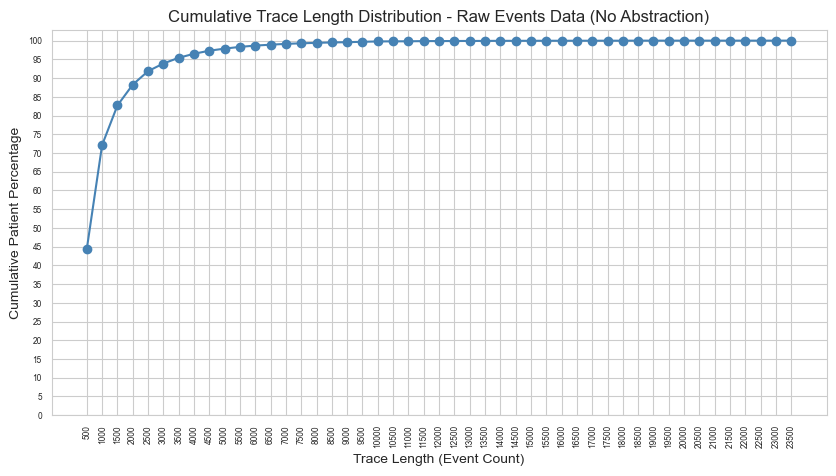

In [12]:
plt.figure(figsize=(10, 5))  # Create a new figure with specified size

# hist_data_raw[0] - array([5.479e+03, 3.430e+03, 1.307e+03, 6.870e+02, 4.440e+02, 2.530e+02,
#        1.880e+02, 1.330e+02, 1.010e+02, 6.900e+01, 5.700e+01, 4.300e+01,
#        2.900e+01, 2.800e+01, 1.800e+01, 1.600e+01, 1.200e+01, 9.000e+00,
#        1.300e+01, 1.200e+01, 3.000e+00, 2.000e+00, 6.000e+00, 1.000e+00,
#        2.000e+00, 2.000e+00, 1.000e+00, 3.000e+00, 0.000e+00, 1.000e+00,
#        1.000e+00, 0.000e+00, 1.000e+00, 0.000e+00, 1.000e+00, 0.000e+00,
#        2.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
#        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 1.000e+00])

# hist_data_raw[1] - array([    0,   500,  1000,  1500,  2000,  2500,  3000,  3500,  4000,
#        4500,  5000,  5500,  6000,  6500,  7000,  7500,  8000,  8500,
#        9000,  9500, 10000, 10500, 11000, 11500, 12000, 12500, 13000,
#       13500, 14000, 14500, 15000, 15500, 16000, 16500, 17000, 17500,
#       18000, 18500, 19000, 19500, 20000, 20500, 21000, 21500, 22000,
#       22500, 23000, 23500])

# Calculate cumulative distribution
cumulative_count = np.cumsum(hist_data_raw[0])

#print(cumulative_count)
#[ 5479  8909 10216 10903 11347 11600 11788 11921 12022 12091 12148 12191
# 12220 12248 12266 12282 12294 12303 12316 12328 12331 12333 12339 12340
# 12342 12344 12345 12348 12348 12349 12350 12350 12351 12351 12352 12352
# 12354 12354 12354 12354 12354 12354 12354 12354 12354 12354 12355]

# Plot cumulative distribution
# consider x-axis to be start from index 1. Index 0 is zero. Index 2 is 100, index 2 is 200 so on (when the step size is 100).

plt.plot(hist_data_raw[1][1:], (cumulative_count / patient_count) * 100, linestyle='-', marker='o', color= '#4682B4')

# Set x ticks
plt.xticks(hist_data_raw[1][1:], rotation='vertical', fontsize=6)

# Set y ticks
plt.yticks(range(0, 105, 5), fontsize=6)

# Labeling
plt.xlabel('Trace Length (Event Count)')
plt.ylabel('Cumulative Patient Percentage')
plt.title('Cumulative Trace Length Distribution - Raw Events Data (No Abstraction)')

# Add grid
plt.grid(True)

# Show plot
plt.show()


## 1.3 Analyse trace length Stats

In [13]:
# Convert list to Pandas Series
series_seq_lengths = pd.Series(list_seq_lengths_raw_event_log)

# Get descriptive statistics
stats_trace_length_row_data = series_seq_lengths.describe()

print(stats_trace_length_row_data)

Distinc_events_without_abstraction = raw_event_log_TP_and_TN_only['event'].nunique()
print(Distinc_events_without_abstraction) # 13194

count    12355.000000
mean       992.865156
std       1316.541650
min         21.000000
25%        315.000000
50%        565.000000
75%       1097.500000
max      23031.000000
dtype: float64
13194


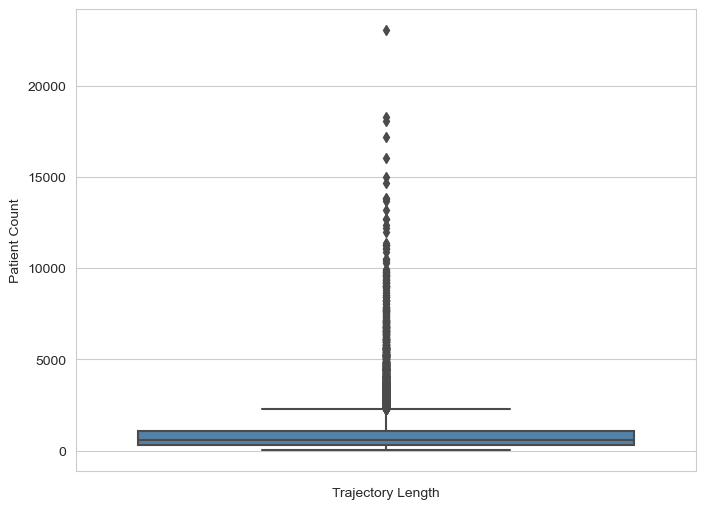

In [14]:
#box plot for trace lengths (without abstration)

# Create a box plot using seaborn
plt.figure(figsize=(8, 6))  # Optional: adjust the size of the plot
sns.boxplot(y=series_seq_lengths, color= '#4682B4')

# Add labels and title (optional)
#plt.title('Box Plot of Sequence Lengths (Abstracted)')
plt.xlabel('Trajectory Length')
plt.ylabel('Patient Count')

# Show the plot
plt.show()


## Save raw event log of only 10% of TP/TN cases (randomly selected) to analyse in DISCO

In [15]:
# Randomly select 1000 unique hadm_ids
unique_hadm_ids = raw_event_log_TP_and_TN_only['hadm_id'].unique()
sampled_hadm_ids = pd.Series(unique_hadm_ids).sample(n=1000, random_state=1).tolist()

# Step 2: Filter the DataFrame to include only rows with the sampled hadm_ids
filtered_df = raw_event_log_TP_and_TN_only[raw_event_log_TP_and_TN_only['hadm_id'].isin(sampled_hadm_ids)]

In [16]:
file_path = '/Users/psenevirathn/Desktop/PhD/Coding/Trajectories/Input/Event_of_only_10_percent_of_hadmids_from_only_TP_and_TN.csv'
#filtered_df.to_csv(file_path, index=False)

# 2. Analysing Trajectory lengths Distribution WITH Abstraction

In [17]:
# Import Abstracted Event log (but this log contain all the patients, not only TP and TN cases)
# Below is the event log WITH admission and discharges.
# However, the evnt log used by our final model is the log WITHOUT admission and discharge records, but still for this length analysis, we used the log WITH admission and discharge records (coz we considered those event when analysed trace length WITHOUT abstractions too)

events_WITH_abstraction = pd.read_csv('/Users/psenevirathn/Desktop/PhD/Coding/Trajectories/Input/Input_for_clustering/May8_v1.csv') # WITH admission and discharge records
# May15_v1.csv # WITH admission and discharge records
# May8_v1.csv # WITHOUT admission and discharge records


In [18]:
# join event log with patients class (TP/TN/FP/FN)
full_abstracted_event_log_with_patient_class = pd.merge(events_WITH_abstraction, both_train_test_labels, on='hadm_id', how='left')[
        ['hadm_id', 'event', 'event_time', 'HIT_label_actual', 'HIT_label_predicted', 'class']]

# Only filter TP and TN patients
abstracted_event_log_TP_and_TN_only = full_abstracted_event_log_with_patient_class[
        (full_abstracted_event_log_with_patient_class['class'] == 'TP') | (full_abstracted_event_log_with_patient_class['class'] == 'TN')]
# 12355 - hadm_ids

In [19]:
seq_length_abstracted_event_log = abstracted_event_log_TP_and_TN_only.groupby('hadm_id').agg(count=('hadm_id', lambda x: len(x)),
                                                        sequence=('event', lambda x: x)).reset_index()

seq_length_abstracted_event_log.sort_values(by='count', ascending=False, inplace=True)

## 1.1 Plot trace length distribution as a Histogram

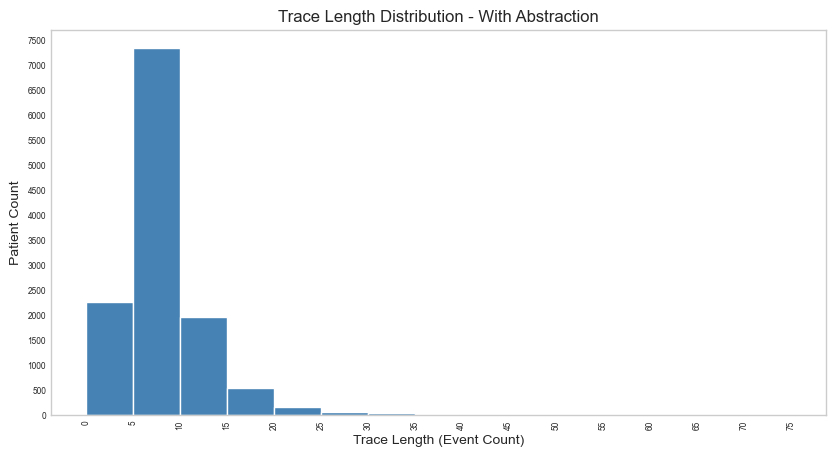

In [27]:
plt.figure(figsize=(10, 5))  # Create a new figure with specified size

list_seq_lengths_abstracted_event_log = seq_length_abstracted_event_log['count'].tolist()

# Custom bins
bins_abstracted = list(range(0, max(list_seq_lengths_abstracted_event_log)+5, 5)) # 73

# Plot histogram
hist_data_abstracted = plt.hist(list_seq_lengths_abstracted_event_log, bins=bins_abstracted, color='#4682B4') 

#print(hist_data_abstracted)
#(array([7.600e+01, 7.655e+03, 3.403e+03, 8.290e+02, 2.450e+02, 7.400e+01, 4.400e+01, 7.000e+00, 1.000e+01, 7.000e+00, 1.000e+00, 0.000e+00, 1.000e+00, 1.000e+00, 2.000e+00]),
 #array([ 0,  5, 10, 15, 20, 25, 30, 35, 40, 45, 50, 55, 60, 65, 70, 75]),
 
# colours for the plot - edgecolor='black', colors - 87CEEB - Light blue , Steel Blue: #4682B4 Light Green: #98FB98 , Cornflower Blue: #6495ED, Light Pink: #FFB6C1 , Light Gray: #D3D3D3 # FA8072 - Salmon pink

# Set x ticks
plt.xticks(bins_abstracted, rotation='vertical', fontsize=6)

# Set y ticks

# print(plt.hist(list_seq_lengths_of_each_hadm_id_when_HIT_positive, bins=bins)) # returns an array of two arrays, where first array contain frquency of each bin, and the second array contain bin edges values

plt.yticks(range(0, int(max(hist_data_abstracted[0]) + 500), 500),fontsize=6) # int(max(hist_data_abstracted[0]) - patient count of the highest bar

# Add axis labels and title
plt.xlabel('Trace Length (Event Count)')
plt.ylabel('Patient Count')
plt.title('Trace Length Distribution - With Abstraction')

# Add grid
plt.grid(False)

# Show plot
plt.show()


## 1.2 Plot Cumulative trace length distribution as a Histogram

In [21]:
patient_count = seq_length_abstracted_event_log['hadm_id'].nunique() # 12355

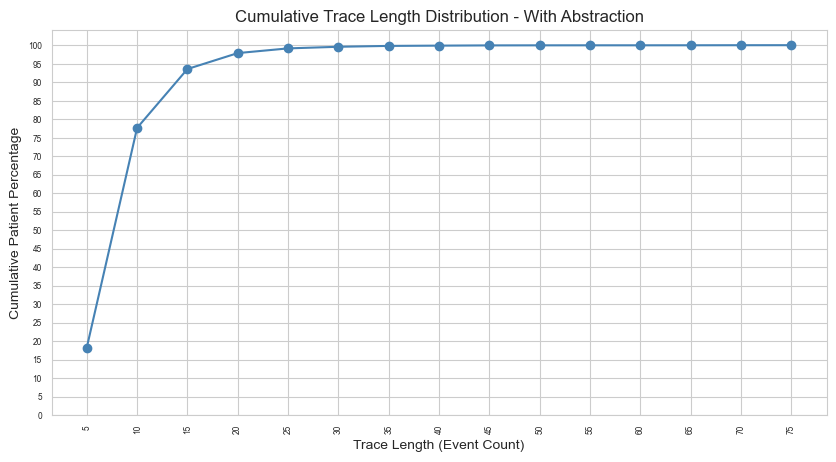

In [22]:
plt.figure(figsize=(10, 5))  # Create a new figure with specified size

# Calculate cumulative distribution
cumulative_count_abstracted = np.cumsum(hist_data_abstracted[0])

# hist_data_abstracted[0] - array([7.600e+01, 7.655e+03, 3.403e+03, 8.290e+02, 2.450e+02, 7.400e+01, 4.400e+01, 7.000e+00, 1.000e+01, 7.000e+00, 1.000e+00, 0.000e+00, 1.000e+00, 1.000e+00, 2.000e+00])
# hist_data_abstracted[1] - hist_data_abstracted

# Plot cumulative distribution
# consider x-axis to be start from index 1. Index 0 is zero. Index 2 is 100, index 2 is 200 so on (when the step size is 100).

plt.plot(hist_data_abstracted[1][1:], (cumulative_count_abstracted / patient_count) * 100, linestyle='-', marker='o', color= '#4682B4')

# Set x ticks
plt.xticks(hist_data_abstracted[1][1:], rotation='vertical', fontsize=6)

# Set y ticks
plt.yticks(range(0, 105, 5), fontsize=6)

# Labeling
plt.xlabel('Trace Length (Event Count)')
plt.ylabel('Cumulative Patient Percentage')
plt.title('Cumulative Trace Length Distribution - With Abstraction')

# Add grid
plt.grid(True)

# Show plot
plt.show()

## 1.3 Analyse trace length Stats

In [23]:
# Convert list to Pandas Series
series_seq_lengths_abstracted = pd.Series(list_seq_lengths_abstracted_event_log)

# Get descriptive statistics
stats_trace_length_abstracted = series_seq_lengths_abstracted.describe()

print(stats_trace_length_abstracted)

Distinc_events = abstracted_event_log_TP_and_TN_only['event'].nunique()
print(Distinc_events) # 49

count    12355.000000
mean         7.684824
std          4.373218
min          2.000000
25%          5.000000
50%          7.000000
75%          9.000000
max         72.000000
dtype: float64
47


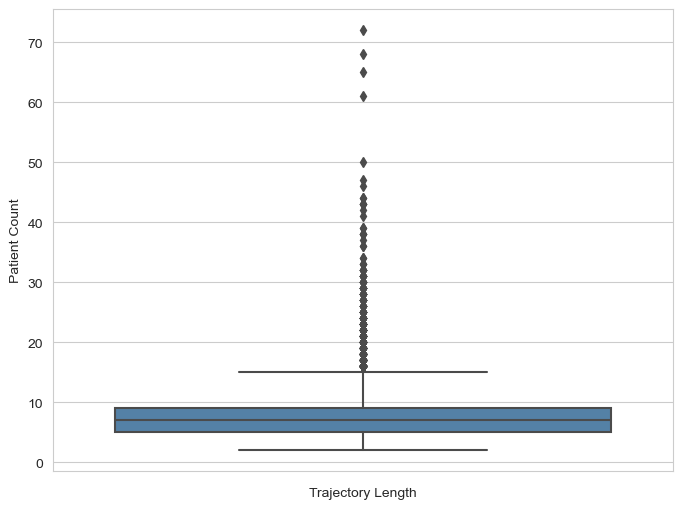

In [24]:
#box plot for trace lengths (with abstration)

# Create a box plot using seaborn
plt.figure(figsize=(8, 6))  # Optional: adjust the size of the plot
sns.boxplot(y=series_seq_lengths_abstracted, color= '#4682B4')

# Add labels and title (optional)
#plt.title('Box Plot of Sequence Lengths (Abstracted)')
plt.xlabel('Trajectory Length')
plt.ylabel('Patient Count')

# Show the plot
plt.show()


# HIT classifier - LIKELIHHOD RATIOS PLOT (T_PLOT)

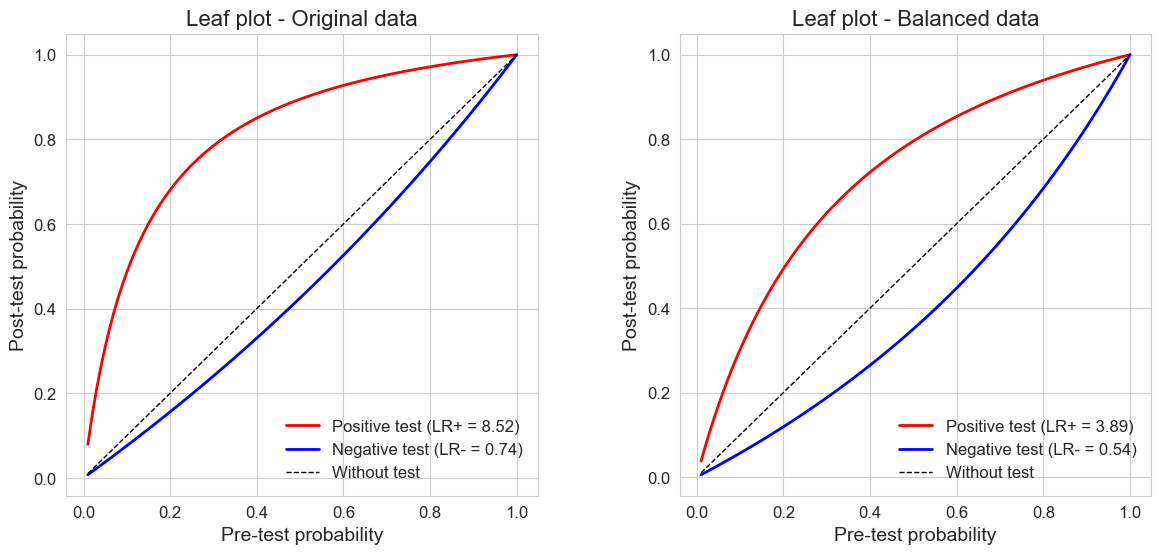

In [25]:
# 1. Import Libraries


import matplotlib.pyplot as plt
from scipy.interpolate import interp1d
import seaborn as sns


# ------------------------------------
# # 2. Likelihood ratios - leaf plot

x_new = [0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07, 0.08, 0.09, 0.1, 0.11, 0.12, 0.13, 0.14, 0.15, 0.16, 0.17, 0.18,
         0.19, 0.2, 0.21, 0.22, 0.23, 0.24, 0.25, 0.26, 0.27, 0.28, 0.29, 0.3, 0.31, 0.32, 0.33, 0.34, 0.35, 0.36, 0.37,
         0.38, 0.39, 0.4, 0.41, 0.42, 0.43, 0.44, 0.45, 0.46, 0.47, 0.48, 0.49, 0.5, 0.51, 0.52, 0.53, 0.54, 0.55, 0.56,
         0.57, 0.58, 0.59, 0.6, 0.61, 0.62, 0.63, 0.64, 0.65, 0.66, 0.67, 0.68, 0.69, 0.7, 0.71, 0.72, 0.73, 0.74, 0.75,
         0.76, 0.77, 0.78, 0.79, 0.8, 0.81, 0.82, 0.83, 0.84, 0.85, 0.86, 0.87, 0.88, 0.89, 0.9, 0.91, 0.92, 0.93, 0.94,
         0.95, 0.96, 0.97, 0.98, 0.99, 1]

y_positiveLR_original = [0.0792410714285714,	0.148122392211405,	0.20855091383812,	0.261992619926199,	0.309593023255814,	0.35226019845645,	0.390723270440252,	0.425574425574426,	0.457299618320611,	0.486301369863014,	0.512915936952715,	0.537426408746846,	0.560072815533981,	0.581060015588465,	0.600563909774436,	0.618736383442266,	0.635709269662921,	0.651597552685248,	0.666501976284585,	0.680511182108626,	0.69370347394541,	0.706148282097649,	0.717907385697538,	0.729035938391329,	0.739583333333333,	0.749593936112615,	0.759107708553326,	0.768160741885626,	0.776785714285714,	0.785012285012285,	0.792867435158501,	0.80037576326914,	0.807559742647059,	0.814439946018893,	0.821035242290749,	0.827362969356927,	0.833439086294416,	0.839278307756118,	0.844894222945484,	0.850299401197605,	0.855505485893417,	0.860523278183917,	0.865362811791383,	0.87003341997772,	0.874543795620438,	0.878902045209903,	0.883115737473536,	0.887191947240542,	0.891137295081967,	0.894957983193277,	0.898659827928524,	0.902248289345064,	0.905728498074454,	0.90910527979766,	0.912383177570094,	0.915566472213694,	0.918659200968523,	0.921665174574754,	0.924587992937022,	0.927431059506531,	0.930197594501718,	0.932890647075445,	0.935513106525376,	0.938067712634187,	0.940557065217391,	0.942983632948752,	0.945349761526232,	0.947657681235279,	0.949909513960703,	0.952107279693487,	0.954252902574457,	0.956348216512846,	0.958394970414201,	0.960394833048989,	0.962349397590361,	0.964260185847034,	0.966128652214892,	0.967956187368912,	0.969744121715076,	0.971493728620296,	0.973206227436823,	0.974882786336236,	0.976524524966858,	0.978132516947299,	0.979707792207792,	0.981251339190058,	0.982764106915571,	0.984247006931317,	0.985700915141431,	0.987126673532441,	0.988525091799266,	0.989896948878561,	0.991242994395516,	0.992563950029744,	0.993860510805501,	0.995133346311077,	0.996383101851852,	0.997610399541197,	0.998815839333081,	1]

y_negativeLR_original = [0.00741929015440144,	0.0148773622838762,	0.0223745212658738,	0.0299110751818917,	0.0374873353596758,	0.045103616416091,	0.0527602363006722,	0.0604575163398693,	0.0681957812819988,	0.0759753593429158,	0.0837965822524192,	0.0916597853014038,	0.0995653073897744,	0.107513491075135,	0.115504682622268,	0.123539232053422,	0.131617493199414,	0.139739823751574,	0.147906585314538,	0.156118143459916,	0.164374867780834,	0.172677131947391,	0.181025313763029,	0.189419795221843,	0.197860962566845,	0.206349206349206,	0.214884921488492,	0.223468507333909,	0.232100367726584,	0.240780911062907,	0.24951055035893,	0.258289703315881,	0.267118792386786,	0.27599824484423,	0.284928492849285,	0.293909973521624,	0.302943129010843,	0.312028406569019,	0.321166258624527,	0.330357142857143,	0.339601522274457,	0.348899865289627,	0.358252645800495,	0.367660343270099,	0.377123442808607,	0.386642435256701,	0.396217817270449,	0.405850091407678,	0.415539766215906,	0.425287356321839,	0.435093382522481,	0.444958371877891,	0.454882857805614,	0.464867380176826,	0.474912485414236,	0.48501872659176,	0.495186663536041,	0.505416862929816,	0.515709898417198,	0.5260663507109,	0.53648680770145,	0.546971864568431,	0.557522123893805,	0.568138195777351,	0.578820697954272,	0.589570255915017,	0.600387503027367,	0.611273080660836,	0.622227638313429,	0.633251833740831,	0.644346333088055,	0.655511811023622,	0.666748950876327,	0.678058444774641,	0.68944099378882,	0.700897308075773,	0.712428107026757,	0.724034119417963,	0.735716083564057,	0.747474747474748,	0.759310869014441,	0.771225216065074,	0.78321856669217,	0.795291709314227,	0.807445442875481,	0.819680577022154,	0.831997932282244,	0.844398340248963,	0.85688264376789,	0.869451697127937,	0.882106366256222,	0.89484752891693,	0.907676074914271,	0.920592906299629,	0.933598937583001,	0.946695095948827,	0.959882321476331,	0.973161567364466,	0.986533800161594,	1]

y_positiveLR_balanced = [0.0378073670910681,	0.073548875023634,	0.107389343885157,	0.139476514879885,	0.169943206640454,	0.19890915288904,	0.22648257506446,	0.252761533463288,	0.27783509245298,	0.301784328937161,	0.324683208134153,	0.346599346599347,	0.367594679072472,	0.387726043001566,	0.407045692361353,	0.425601750547046,	0.443438610608194,	0.460597289830286,	0.477115744625912,	0.493029150823828,	0.508370153712116,	0.523169091575987,	0.537454195951222,	0.551251771374587,	0.564586357039187,	0.577480872444901,	0.589956748862551,	0.602034048198099,	0.613731570643599,	0.625066952329941,	0.636056754048209,	0.646716541978387,	0.657060961253007,	0.667103803086856,	0.676858066119811,	0.68633601254656,	0.695549219542841,	0.704508626441712,	0.713224578064031,	0.721706864564007,	0.729964758112499,	0.73800704670702,	0.745842065367637,	0.753477724951576,	0.760921538795914,	0.768180647377007,	0.775261841156765,	0.782171581769437,	0.788916021687844,	0.795501022494888,	0.801932171874368,	0.808214799424644,	0.814353991389185,	0.820354604389596,	0.826221278239042,	0.831958447907119,	0.837570354701016,	0.843061056722218,	0.848434438652915,	0.853694220921727,	0.858843968294184,	0.863887097929651,	0.868826886942957,	0.873666479505895,	0.878408893520931,	0.883057026896884,	0.887613663454007,	0.892081478483745,	0.896463043986507,	0.900760833608998,	0.904977227301026,	0.909114515710205,	0.913174904331608,	0.917160517428153,	0.921073401736385,	0.924915529971218,	0.92868880414225,	0.932395058693381,	0.936036063476592,	0.939613526570048,	0.943129096949924,	0.946584367024749,	0.949980875040457,	0.953320107363753,	0.956603500650947,	0.959832443908877,	0.963008280454145,	0.966132309776473,	0.969205789311609,	0.972229936128853,	0.975205928537976,	0.978134907619985,	0.981017978685902,	0.983856212667492,	0.986650647443599,	0.989402289105553,	0.992112113164883,	0.994781065706383,	0.997410064489394,	1]

y_negativeLR_balanced = [0.0054249547920434,	0.0109002825999193,	0.0164266882985196,	0.0220048899755501,	0.0276356192425793,	0.0333196215549157,	0.0390576565406076,	0.0448504983388704,	0.0506989359482579,	0.0566037735849057,	0.0625658310511902,	0.0685859441151566,	0.0746649649010849,	0.0808037622915776,	0.0870032223415682,	0.0932642487046632,	0.0995877630722499,	0.105974705625818,	0.112426035502959,	0.118942731277533,	0.125525791454505,	0.132176234979973,	0.138895101766943,	0.14568345323741,	0.152542372881356,	0.159472966833258,	0.166476364466773,	0.173553719008264,	0.180706208169859,	0.187935034802784,	0.195241427571728,	0.202626641651032,	0.210091959443527,	0.217638691322902,	0.225268176400477,	0.232981783317354,	0.240780911062907,	0.24866698982065,	0.256641481842554,	0.264705882352941,	0.272861720483116,	0.281110560237977,	0.289454001495886,	0.297893681043129,	0.306431273644388,	0.315068493150685,	0.323807093646338,	0.33264887063655,	0.341595662277304,	0.350649350649351,	0.359811863078129,	0.369085173501577,	0.37847130388786,	0.387972325705162,	0.397590361445783,	0.407327586206897,	0.417186229330442,	0.427168576104746,	0.437276969530607,	0.447513812154696,	0.457881567973311,	0.468382764409625,	0.479019994367784,	0.489795918367347,	0.500713266761769,	0.511774842044802,	0.522983521248916,	0.534342258440047,	0.545854087313214,	0.557522123893805,	0.569349569349569,	0.58133971291866,	0.59349593495935,	0.60582171012735,	0.618320610687023,	0.6309963099631,	0.643852585939919,	0.656893325015596,	0.670122525918944,	0.683544303797468,	0.697162894485177,	0.710982658959538,	0.725008087997412,	0.739243807040417,	0.753694581280788,	0.768365320979484,	0.78326108702901,	0.798387096774194,	0.813748730104978,	0.829351535836177,	0.845201238390093,	0.86130374479889,	0.87766515204474,	0.894291754756871,	0.911190053285968,	0.92836676217765,	0.945828819068256,	0.963583394027677,	0.981637899375689,	1]

# Create a figure with subplots
fig, axes = plt.subplots(1, 2, figsize=(14, 6))  # Adjust the figure size

# Use seaborn style for improved aesthetics
plt.style.use('seaborn-whitegrid')

# Plot for original data (left plot)
f1 = interp1d(x_new, y_positiveLR_original, kind='quadratic')
y1_smooth = f1(x_new)
axes[0].plot(x_new, y1_smooth, color='r', label='Positive test (LR+ = 8.52)', linewidth=2)

f2 = interp1d(x_new, y_negativeLR_original, kind='quadratic')
y2_smooth = f2(x_new)
axes[0].plot(x_new, y2_smooth, color='b', label='Negative test (LR- = 0.74)', linewidth=2)

axes[0].plot(x_new, x_new, linestyle='--', color='k', label='Without test', linewidth=1)

axes[0].set_xlabel('Pre-test probability', fontsize=14)
axes[0].set_ylabel('Post-test probability', fontsize=14)
axes[0].legend(loc="lower right", fontsize=12)
axes[0].set_title("Leaf plot - Original data", fontsize=16)
axes[0].tick_params(axis='both', labelsize=12)

# Plot for balanced data (right plot)
f3 = interp1d(x_new, y_positiveLR_balanced, kind='quadratic')
y3_smooth = f3(x_new)
axes[1].plot(x_new, y3_smooth, color='r', label='Positive test (LR+ = 3.89)', linewidth=2)

f4 = interp1d(x_new, y_negativeLR_balanced, kind='quadratic')
y4_smooth = f4(x_new)
axes[1].plot(x_new, y4_smooth, color='b', label='Negative test (LR- = 0.54)', linewidth=2)

axes[1].plot(x_new, x_new, linestyle='--', color='k', label='Without test', linewidth=1)

axes[1].set_xlabel('Pre-test probability', fontsize=14)
axes[1].set_ylabel('Post-test probability', fontsize=14)
axes[1].legend(loc="lower right", fontsize=12)
axes[1].set_title("Leaf plot - Balanced data", fontsize=16)
axes[1].tick_params(axis='both', labelsize=12)

# Adjust layout and spacing
plt.subplots_adjust(wspace=0.3)  # Adjust the space between subplots

# Display the plot
plt.show()
# python 8_Jan_3_LR_curve_and_Feature_Importance.py
